In [1]:
import string
import re
from numpy import array,argmax,random,take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM, Embedding, Bidirectional,RepeatVector,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth',200)

In [2]:
def read_text(filename):
    file=open(filename,mode='rt',encoding='utf-8')
    text=file.read()
    file.close()
    return text

In [3]:
#split text into sentences
def to_lines(text):
    sen=text.strip().split('\n')
    sen=[i.split('\t')for i in sen]
    return sen

In [4]:
data=read_text(r"C:\Users\Hp\Documents\deu.txt")
deu_eng=to_lines(data)
deu_eng=array(deu_eng)

In [5]:
deu_eng=deu_eng[:8000,:]

In [6]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Close the book.', 'Mach das Buch zu.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2245184 (CK) & #3695596 (Esperantostern)'],
       ['Close the cage.', 'Mach den Käfig zu.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #7966241 (adiante19) & #8244936 (MisterTrouser)'],
       ['Close the cage.', 'Macht den Käfig zu.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #7966241 (adiante19) & #8244938 (MisterTrouser)']],
      dtype='<U537')

#### TEXT TO SEQUENCE CONVERSION


In [7]:
eng_1=[]
deu_1=[]
for i in deu_eng[:,0]:
    eng_1.append(len(i.split()))
for i in deu_eng[:,1]:
    deu_1.append(len(i.split()))


In [8]:
length_df=pd.DataFrame({'eng':eng_1,'deu':deu_1})

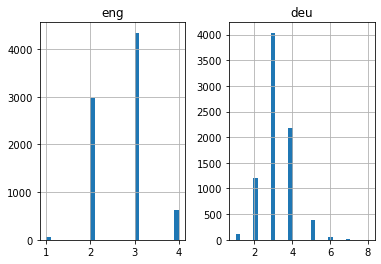

In [9]:
length_df.hist(bins=30)
plt.show()

In [10]:
#function to build a tokenizer
def tokenization(lines):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [11]:
#preparing english tokenizer
eng_tokenizer=tokenization(deu_eng[:,0])
eng_vocab_size=len(eng_tokenizer.word_index)+1

eng_length=8
print('English Vocabulary size: %d' % eng_vocab_size )

English Vocabulary size: 1839


In [12]:
#preparing German Tokenizer
deu_tokenizer=tokenization(deu_eng[:,1])
deu_vocab_size=len(deu_tokenizer.word_index)+1
deu_length=8
print('Deutch Vocabulary size: %d' % deu_vocab_size )

Deutch Vocabulary size: 3067


In [13]:
def encode_sequences(tokenizer,length,lines):
    seq=tokenizer.texts_to_sequences(lines)
    seq=pad_sequences(seq,maxlen=length,padding='post')
    return seq

In [14]:
#model Building
from sklearn.model_selection import train_test_split
train,test=train_test_split(deu_eng,test_size=0.2, random_state=12)

In [15]:
trainX=encode_sequences(deu_tokenizer,deu_length,train[:,1])
trainY=encode_sequences(eng_tokenizer,eng_length,train[:,0])

In [16]:
testX=encode_sequences(deu_tokenizer,deu_length,test[:,1])
testY=encode_sequences(eng_tokenizer,eng_length,test[:,0])

In [17]:
def build_model(in_vocab,out_vocab,in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab,units,input_length=in_timesteps,mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units,return_sequences=True))
    model.add(Dense(out_vocab,activation='softmax'))
    return model

In [18]:
model=build_model(deu_vocab_size,eng_vocab_size,deu_length,eng_length,512)
rms=optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms,loss='sparse_categorical_crossentropy')

In [19]:
filename='model.h1.24_shreya'
checkpoint=ModelCheckpoint(filename,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
history=model.fit(trainX,trainY.reshape(trainY.shape[0],trainY.shape[1],1),
                 epochs=30,batch_size=512,
                 validation_split=0.2,
                 callbacks=[checkpoint],verbose=1)

Epoch 1/30
10/10 [==============================] - 23s 2s/step - loss: 3.9945 - val_loss: 2.4482

Epoch 00001: val_loss improved from inf to 2.44816, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 2.3384 - val_loss: 2.2185

Epoch 00002: val_loss improved from 2.44816 to 2.21848, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 3/30
10/10 [==============================] - 15s 2s/step - loss: 2.1306 - val_loss: 2.0566

Epoch 00003: val_loss improved from 2.21848 to 2.05662, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 4/30
10/10 [==============================] - 16s 2s/step - loss: 2.0039 - val_loss: 1.9968

Epoch 00004: val_loss improved from 2.05662 to 1.99684, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 5/30
10/10 [==============================] - 24s 2s/step - loss: 1.9384 - val_loss: 1.9930

Epoch 00005: val_loss improved from 1.99684 to 1.99301, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 6/30
10/10 [==============================] - 23s 2s/step - loss: 1.8890 - val_loss: 1.9521

Epoch 00006: val_loss improved from 1.99301 to 1.95210, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 7/30
10/10 [==============================] - 23s 2s/step - loss: 1.8698 - val_loss: 1.9482

Epoch 00007: val_loss improved from 1.95210 to 1.94821, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 8/30
10/10 [==============================] - 22s 2s/step - loss: 1.8363 - val_loss: 1.9272

Epoch 00008: val_loss improved from 1.94821 to 1.92723, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 9/30
10/10 [==============================] - 27s 3s/step - loss: 1.8176 - val_loss: 1.9301

Epoch 00009: val_loss did not improve from 1.92723
Epoch 10/30
10/10 [==============================] - 27s 3s/step - loss: 1.7760 - val_loss: 1.9087

Epoch 00010: val_loss improved from 1.92723 to 1.90873, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 11/30
10/10 [==============================] - 21s 2s/step - loss: 1.7332 - val_loss: 1.9378

Epoch 00011: val_loss did not improve from 1.90873
Epoch 12/30
10/10 [==============================] - 20s 2s/step - loss: 1.6922 - val_loss: 1.8656

Epoch 00012: val_loss improved from 1.90873 to 1.86563, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 13/30
10/10 [==============================] - 21s 2s/step - loss: 1.6652 - val_loss: 1.8470

Epoch 00013: val_loss improved from 1.86563 to 1.84697, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 14/30
10/10 [==============================] - 26s 3s/step - loss: 1.6172 - val_loss: 1.8308

Epoch 00014: val_loss improved from 1.84697 to 1.83084, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 15/30
10/10 [==============================] - 23s 2s/step - loss: 1.5712 - val_loss: 1.8006

Epoch 00015: val_loss improved from 1.83084 to 1.80056, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 16/30
10/10 [==============================] - 22s 2s/step - loss: 1.5289 - val_loss: 1.7368

Epoch 00016: val_loss improved from 1.80056 to 1.73684, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 17/30
10/10 [==============================] - 26s 3s/step - loss: 1.4917 - val_loss: 1.7427

Epoch 00017: val_loss did not improve from 1.73684
Epoch 18/30
10/10 [==============================] - 27s 3s/step - loss: 1.4496 - val_loss: 1.7204

Epoch 00018: val_loss improved from 1.73684 to 1.72041, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 19/30
10/10 [==============================] - 26s 3s/step - loss: 1.3929 - val_loss: 1.7257

Epoch 00019: val_loss did not improve from 1.72041
Epoch 20/30
10/10 [==============================] - 27s 3s/step - loss: 1.3748 - val_loss: 1.6729

Epoch 00020: val_loss improved from 1.72041 to 1.67288, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 21/30
10/10 [==============================] - 25s 3s/step - loss: 1.3175 - val_loss: 1.7188

Epoch 00021: val_loss did not improve from 1.67288
Epoch 22/30
10/10 [==============================] - 25s 3s/step - loss: 1.3018 - val_loss: 1.6777

Epoch 00022: val_loss did not improve from 1.67288
Epoch 23/30
10/10 [==============================] - 25s 3s/step - loss: 1.2549 - val_loss: 1.6471

Epoch 00023: val_loss improved from 1.67288 to 1.64706, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 24/30
10/10 [==============================] - 26s 3s/step - loss: 1.2238 - val_loss: 1.6707

Epoch 00024: val_loss did not improve from 1.64706
Epoch 25/30
10/10 [==============================] - 26s 3s/step - loss: 1.1884 - val_loss: 1.6112

Epoch 00025: val_loss improved from 1.64706 to 1.61125, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 26/30
10/10 [==============================] - 28s 3s/step - loss: 1.1629 - val_loss: 1.5848

Epoch 00026: val_loss improved from 1.61125 to 1.58483, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 27/30
10/10 [==============================] - 29s 3s/step - loss: 1.1309 - val_loss: 1.5667

Epoch 00027: val_loss improved from 1.58483 to 1.56669, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 28/30
10/10 [==============================] - 27s 3s/step - loss: 1.1021 - val_loss: 1.5646

Epoch 00028: val_loss improved from 1.56669 to 1.56457, saving model to model.h1.24_shreya


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


INFO:tensorflow:Assets written to: model.h1.24_shreya\assets


Epoch 29/30
10/10 [==============================] - 27s 3s/step - loss: 1.0661 - val_loss: 1.5896

Epoch 00029: val_loss did not improve from 1.56457
Epoch 30/30
10/10 [==============================] - 29s 3s/step - loss: 1.0362 - val_loss: 1.5775

Epoch 00030: val_loss did not improve from 1.56457


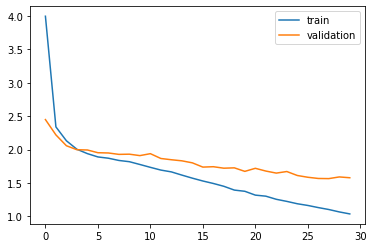

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [21]:
import numpy as np
model=load_model('model.h1.24_shreya')
preds= np.argmax(model.predict(testX.reshape(testX.shape[0],testX.shape[1])),axis=1)


In [22]:
def get_word(n,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==n:
            return word
    return None

In [23]:
preds_text=[]
for i in preds:
    temp=[]
    for j in range(len(i)):
        t=get_word(i[j],eng_tokenizer)
        if j>0:
            if(t==get_word(i[j-1],eng_tokenizer)) or (t==None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t==None):
                temp.append('')
            else:
                temp.append(t)
    preds_text.append(''.join(temp))

In [24]:
pred_df=pd.DataFrame({'actual':test[:,0],'predicted':preds_text})

In [25]:
pd.set_option('display.max_colwidth',200)

In [26]:
pred_df.head(15)

,actual,predicted
0,That's OK.,atomiitomitomiitomtomtomiitomtomitomiiitomitomiiiitomitomtomiitomiitomitomitomitomitomiitomitomitomitomtomitomiitomiitomiitomiitomtomitomitomitomitomitomitomitomitomtomitomitomitomitomiitomitomito...
1,I am American.,atomiiiitomiitomiitomiitomitomitomiiiitomtomitomitomitomitomitomitomitomitomitomitomitomitomitomitomiiitomitomitomitomiitomitomiitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomiiitomit...
2,I'm eating.,atomitomiitomitomitomiitomitomitomitomitomiitomitomitomiiitomtomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomiitomitomitomitomitomitomitomitomitomitomitomito...
3,They're cold.,aiiiiitomiiiiiiitomitomiiitomitomitomitomiitomitomitomitomitomitomitomitomtomtomitomitomtomiitomitomiitomitomitomtomtomitomitomitomitomitomtomitomitomitomtomtomitomitomitomiitomitomitomitomtomiito...
4,Be sensible.,aiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiitomiiitomitomiiiiiitomiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiitomiiitomiiiiiiitomiiiiiiiiiiiiiiiitomiiiiiiiiiiiiiiiiiiiiiiiiiiiii...
5,It was pretty.,aitomitomtomtomitomtomitomtomtomitomiitomitomitomitomiitomtomitomitomtomitomtomitomitomitomitomitomtomtomitomitomititomitomitomiitomitomtomitomtomitomitomiititomitomtomitomtomitomitomtomitomtomtom...
6,I'll tell Tom.,atomitomitomitomitomitomiitomiitomtomitomiitomitomitomitomiiitomitomtomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomiitomitomitomitomitomitomitomitomitomitomitomitomitom...
7,OK. Go ahead.,aiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiitomiiitomitomiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiitomiiiiiiiiiiitomiiiiiiiiiiiitomiiiitomiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...
8,Aim. Fire!,aiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii
9,Bring it here.,atomiitomitomitomtomitomtomitomtomtomitomiitomitomtomitomiiiitomitomtomitomitomitomitomtomitomitomitomitomitomitomitomitomtomitomitomtomitomitomitomitomiitomtomitomtomtomitomitomiititomitomtomitom...


In [27]:
pred_df.tail(15)

,actual,predicted
1585,I looked down.,atomitomitomitomitomiitomitomitomitomiitomitomitomitomiiitomitomtomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomiitomitomiitomitomitomitomiititomitomitomitomitomitomitomitit...
1586,I need a coat.,atomitomitomititomitomitomiiititomitomtomiititomiitomitomitiititomitomiitomittomititomitomittomitomitiitiittomiititomitomittomitomitomititomittomitomittomiittomittomitomiititomitiittomitomiittomii...
1587,Send it to me.,atomitomiiiitomtomitomtomtomitomitomtomitomtomitomiiiitomitomtomitomitomitomitomtomitomitomitomitomitomitomtomtomtomitomitomtomiitomitomiitomitomtomitomtomtomitomitomiititomitomtomitomitomitomtomt...
1588,Let's walk.,aitomiiiitomiiiiiiiitomtomitomiiitomitomiitomiiitomitomiitomitomitomiitomiiiitomitomiitomiitomiitomitomitomitomiitomitomiitomitomitomitomtomiitomiiiitomitomiitomitomiitomitomitomitomiitomitomitomi...
1589,Tom is frugal.,aitomitomitomitomtomitomitomtomitomtomtomitomitomtomitomtomitomtomitomiitomtomitomitomitomitomtomitomitomitomitomitomitomitomitomitomitomitomitomitomiitomitomtomitomtomitomitomitomitomitomtomitomi...
1590,It hurts.,aiiiitomiiiiitomitomtomitomitomiiiitomitomiiiiiiitomitomiiiiiiiiitomiiiiiitomiiiiiitomiiiiiiiiiiiiiitomiiiitomiitomiiiitomiiiiiiitomiiiitomtomiitomtomiiiiitomiiiiiiiiiiiiiiiiiiitomiiiiiiiiiiiiiiii...
1591,Tom isn't old.,aitomitomitomitomtomitomitomtomitomtomtomitomitomtomitomtomitomtomitomitomitomitomtomitomitomitomitomtomitomitomtomitomitomitomitomitomitomitomitomitomiitomitomtomitomtomitomitomitomitomitomtomito...
1592,Tom was dying.,aitomitomitomitomtomitomitomtomitomtomitomitomiitomitomitomtomitomitomitomtomitomitomitomitomtomitomitomitomitomitomitomitomitomitomitomititomitomitomitomiitomitomtomitomitomitomitomiititomitomito...
1593,Tom is my dad.,aitomitomiititomitomitomtomitomtomtomitomiitomitomittomitomtomitomiitomittomitomitomitomititomtomitomitomitomitomitomitomitomitomittomittomitomitomitiittomitomitomitomiitomitomtomitomitomitomitomi...
1594,I'll manage.,atomiitomiitomitomitomiitomitomtomitomiitomitomitomiiiitomtomitomitomitomitomitomitomitomitomitomitomitomitomitomitomitomiitomitomitomitomitomitomiiitomitomitomitomitomitomitomitomitomitomitomitom...
